# Trying out Bayesian Flow Networks

Trying out the discrete case.

## Imports

In [1]:
import jax.numpy as jnp
import jax.random as jr
import flax.linen as nn
import jax
import optax
from tqdm import tqdm
from functools import partial
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
import bfn.discrete.loss_and_sample as las
import bfn.discrete.example_data as example_data
import bfn.discrete.training as training
import bfn.discrete.models as models

## Main

## Training Loop

In [3]:
# Creating 100 corrupted versions of my name
reference = "elisroberts"
data = example_data.StringDataset(reference, 100, 0.15)

In [4]:
# Initialize model
model = models.DiscreteOutputDistribution(data.num_cats, (data.d,), models.MultipleMLP(data.num_cats))
thetas_prior = jnp.ones((data.num_cats, data.d)) / data.num_cats

variables = model.init(jr.PRNGKey(0), thetas_prior, 1.0)
params = variables["params"]

In [5]:
optim = optax.adam(1e-3)
opt_state = optim.init(params)

In [6]:
batch_size = 32
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, collate_fn=jnp.stack)

In [7]:
NUM_EPOCHS = 1000
losses = []
key = jr.PRNGKey(0)
beta_1 = 4.0
for _ in (pbar := tqdm(range(NUM_EPOCHS))):
    epoch_loss = 0.0
    for x_batch in dataloader:
        key, subkey = jr.split(key)
        loss, params, opt_state = training.make_step(model, x_batch, optim, opt_state, params, beta_1, key=subkey)
        epoch_loss += loss
    losses.append(epoch_loss)
    pbar.set_description(f"Loss: {epoch_loss:.1f}")

losses = jnp.array(losses)

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 22.8: 100%|██████████| 1000/1000 [00:29<00:00, 33.82it/s]


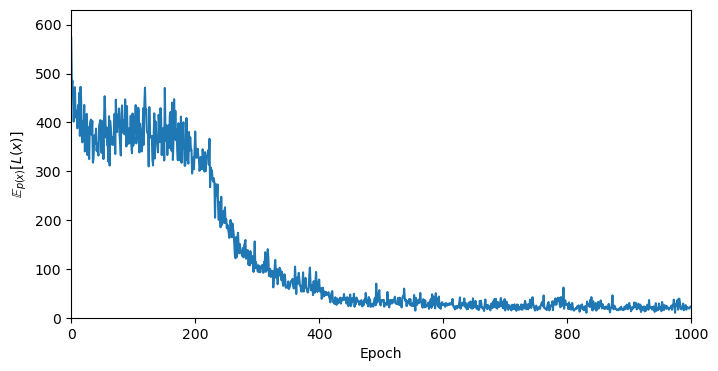

In [8]:
# Plot losses
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(losses)

_ = ax.set_xlabel("Epoch")
_ = ax.set_ylabel(r"$\mathbb{E}_{p(x)}[L(x)]$")  # Not actually the expectation because summing loss in each epoch
_ = ax.set_xlim(0, losses.shape[0])
_ = ax.set_ylim(0, 1.1 * jnp.max(losses))

In [9]:
sample_key = jr.PRNGKey(19)
steps = 1000
output, thetas_output = las.sample(params, model, beta_1, steps, key=sample_key)
sampled_name = example_data.detokenize_string(output)
sampled_name

'elisrocerts'

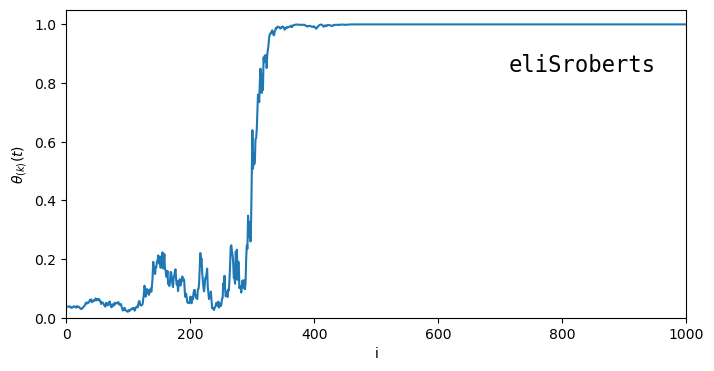

In [10]:
pos = 3
letter = example_data.tokenize_string(reference[pos])
reference_alt = reference[:pos] + reference[pos].upper() + reference[pos + 1:]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(thetas_output[:, letter, pos])

_ = ax.text(int(0.95 * steps), 0.9, reference_alt, fontsize=16, ha="right", va="top", color="k", fontfamily="monospace")

_ = ax.set_xlabel("i")
_ = ax.set_ylabel(r"$\theta_{(k)}(t)$")
_ = ax.set_xlim(0, thetas_output.shape[0])
_ = ax.set_ylim(0, 1.05)